# QISKit の利用方法

In [1]:
#!pip install qiskit -U

In [2]:
# 必要なライブラリをインポートします．
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import compile, BasicAer
# QISKit Aer が量子シミュレータを提供します．
backend = BasicAer.get_backend("qasm_simulator")
# Aer に備わっている "qasm_simulator" を指定します．
# 量子ビットと古典ビットを準備します．
q = QuantumRegister(3, "q")
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")
# 作成する量子ゲート回路を宣言します．
qc = QuantumCircuit(q, c0, c1, c2,name="teleport")
# 量子ビット q[0] を初期状態に準備します．
qc.u3(0.3, 0.2, 0.1, q[0])
# 量子ビット q[1], q[2] でBellペアを作ります．
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier(q) # 状態準備の終わりを示します．  
# Bell基底で q[0], q[1] を測定します．
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c0[0])
qc.measure(q[1], c1[0])
# q[0], q[1] の測定結果に応じたゲート操作を q[2] に施します．
qc.barrier(q)  # Bell基底を測定するまでを示します．
qc.z(q[2]).c_if(c0, 1)
qc.x(q[2]).c_if(c1, 1)
# q[2] を測定します．
qc.measure(q[2], c2[0])
initial_layout = {("q", 0): ("q", 0), ("q", 1): ("q", 1),("q", 2): ("q", 2)}
qobj = compile(qc, backend=backend, coupling_map=None, shots=1024, initial_layout=initial_layout)
job = backend.run(qobj)
print(job.result().get_counts(qc))
# shots で指定した回数測定した結果の分布が得られます．

{'0 0 0': 235, '1 0 1': 4, '0 1 1': 278, '0 0 1': 257, '1 1 0': 6, '1 1 1': 5, '0 1 0': 233, '1 0 0': 6}


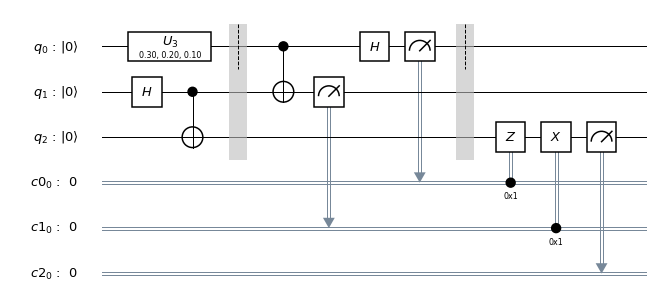

In [3]:
%matplotlib inline
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qc, output="mpl")

# Cirq の利用方法

In [4]:
#!pip install cirq

In [5]:
# 必要なライブラリをインポートします．
import cirq

# 量子ビットと回路を準備します．
qubit = cirq.LineQubit.range(3)
qc = cirq.Circuit()
# ゲート操作（Operation）を追加します．
qc.append([
  cirq.H.on(qubit[1]),
  cirq.CNOT(qubit[1], qubit[2]),
  cirq.H.on(qubit[0]),
  cirq.Z.on(qubit[0])
  ])
qc.append([
  cirq.CNOT(qubit[0], qubit[1]),
  cirq.H.on(qubit[0]),
  cirq.measure(qubit[0]),
  cirq.measure(qubit[1])
  ])
print(qc)     # 回路を表示します．
simulator = cirq.google.XmonSimulator()
result = simulator.run(qc, repetitions=20)
print(result)

0: ───────H───Z───@───H───M───
                  │
1: ───H───@───────X───────M───
          │
2: ───────X───────────────────
0=11001001111111011101
1=00011110010001110011


# pyQuil の利用方法

In [6]:
#!pip install pyquil

In [7]:
#!qvm -S

In [8]:
# 必要なライブラリをインポートします．
import pyquil.quil as pq
from pyquil.gates import *
from pyquil.api import WavefunctionSimulator
# 量子プログラムの準備をします．
qvm = WavefunctionSimulator()
ins = pq.Program()
ro = ins.declare(name='ro', memory_type='BIT', memory_size=3)
ins.inst(H(1), CNOT(1,2)) # Bellペアを作ります．
ins.inst(H(0),Z(0)) # 初期状態を作ります．
# Bell基底で測定し，測定結果に応じたゲート操作します．
ins.inst(CNOT(0,1),H(0))
ins.measure(0,ro[0]).measure(1,ro[1]).if_then(ro[1], X(2)).if_then(ro[0], Z(2))
ins.measure(2,ro[2])
# 量子プログラムを実行します．
for i in range(10):
    q = qvm.wavefunction(ins)
    print(q)

(1+0j)|010>
(1+0j)|010>
(1+0j)|001>
(-1+0j)|111>
(-1+0j)|110>
(1+0j)|001>
(-1+0j)|111>
(1+0j)|010>
(1+0j)|011>
(-1+0j)|101>


# SymPy の利用方法

[(|000>, 1/2), (exp(I*pi/4)*|001>, 1/2)]


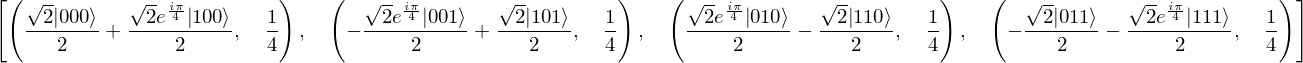

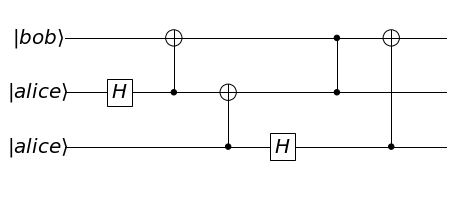

In [9]:
from sympy import *    # SymPy の便利な関数など
init_printing()        # Jupyter Notebook で SymPy 出力を良い感じに出力します

from sympy.physics.quantum import *    # 量子計算のための関数など
from sympy.physics.quantum.qubit import * # 量子ビットのブラ・ケットベクトル、測定に関する関数
from sympy.physics.quantum.gate import *  # 量子ゲート各種
from sympy.physics.quantum.gate import IdentityGate as Id  # Python で I はほかの意味に割当たっているため使えません。恒等変換操作を Id として使えるようにします
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller, Mz,CreateOneQubitGate

# Alice と Bob が対象としている量子ビットを測定する操作を準備します。
def alice(qbit): return measure_partial(qbit,(0,1))
def bob(qbit):  return measure_partial(qbit,(2,))

def U(x): return T(x)*X(x)*H(x)
ini_alice = U(0) * Qubit('000')
print(measure_partial(qapply(ini_alice),(0,)))

# Alice と Bob は量子もつれの状態を共有します。
pairs = CNOT(1,2)*H(1)

# Bell測定を行います。
bell_meas = CNOT(0,2)*CPHASE(1,2)*H(0)*CNOT(0,1)*pairs
CircuitPlot(bell_meas,nqubits=3, labels = ['alice','alice','bob'])
teleportated = qapply(bell_meas*ini_alice)

alice(teleportated)